In [67]:
import pandas as pd
import numpy as np
# import string as s
import seaborn as sns
import sz_toolbox as sz
# import math
# import tables
# import matplotlib
import matplotlib.pyplot as plt
from matplotlib import style, colors
# from itertools import groupby
import matplotlib.patches as patches
from matplotlib import gridspec
import scipy.stats as stats
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, fclusterdata, leaves_list
from scipy.spatial.distance import pdist
# from scipy.ndimage.interpolation import shift
# matplotlib.style.use('ggplot')
# %matplotlib inline
# matplotlib.rcParams['figure.figsize'] = (8, 6)
# matplotlib.rcParams['figure.facecolor'] = 'white'
# import mpl_toolkits.mplot3d.axes3d as p3
# from sklearn.cluster import AgglomerativeClustering
# from sklearn.datasets.samples_generator import make_swiss_roll
# matplotlib.style.use('ggplot')
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
# choose color from here, there is option for color blind safe
# http://colorbrewer2.org/#type=diverging&scheme=RdYlBu&n=4

# 1. Overview

 53 samples in total, 20 hiv+, 18 hiv-, 7 hiv+ controls, 7 hiv- controls
 
 

https://www.bcgsc.ca/jira/browse/DA-167

https://www.bcgsc.ca/jira/browse/PIPE-1102

118 patients are here:

/projects/trans_scratch/validations/workspace/szong/Cervical/mutsig2cv/118_patients.txt 

we lost two hypermutated cases when using 118 patients as discovery cohort.

In [87]:
f1 = '/projects/trans_scratch/validations/workspace/szong/Cervical/mutsig2cv/118_patients.txt'
patients = pd.read_csv(f1, header=None)[0].values.tolist()
assert len(patients) == 118
patients[:3]

['HTMCP-03-06-02001', 'HTMCP-03-06-02002', 'HTMCP-03-06-02003']

# 2. constants for notebook

In [88]:
wkdir = '/projects/da_workspace/DA-167_Cervical_epi_clustering/'
colormap_file = '/projects/trans_scratch/validations/workspace/szong/Cervical/color_maps.txt'
mark = 'H3K4me3'
# mark = 'H3K27ac'
feather_file = f'{wkdir}{mark}_promoter/fold_change_matrix.feather'
covariate_file = f'{wkdir}clinic_covariate_20181009.csv.added'
chiplib_file = f'{wkdir}57_chipseq_samples_library_ids.csv'
overlap = 0.0
# dist = 'correlation'
# link = 'ward'
dist = 'jaccard' # this is jaccard distance 1-jaccard value
link = 'complete'    
png_file = f'{wkdir}/{mark}_{dist}_{link}_{overlap}_heatmap.png'
# need to add logic, if using jaccard distance, transform fold change to 0 and 1


# 3. color map

In [89]:
df_clrs = pd.read_csv(colormap_file, sep='\t', header=None)
color_dict = pd.Series(df_clrs[1].values,index=df_clrs[0]).to_dict()
df_clrs.head(2)
list(color_dict.items())[0]
color_dict['HPV16']

,0,1
0,HPV16,#7F3B08
1,HPV31,#B35806


('HPV16', '#7F3B08')

'#7F3B08'

# 4. get all narrow peak and broad peak files

In [90]:
%%bash -s $wkdir $mark

wkdir=$1
mark=$2
echo $wkdir, $mark
cd $wkdir
ls -1 /projects/chipseq/macs/A*/75nt/hg19a/bwa-mem-0.7.6a-sb/MACS_2.1.1.20160309/*$mark*Peak > a.tmp
cat a.tmp |awk -F "/" '{print $5"\t"$0}'|awk -F "_" '{print $3"\t"$0}'>d.tmp

while read a b c;do grep $b 57_chipseq_samples_library_ids.csv|cut -f 1|\
awk -v lib=$b -v path=$c -v mark=$a -F "-01" '{print $1"\t"lib"\t"mark"\t"path}' ;done \
< d.tmp |sort -k1 -k2 > $mark"_peak_file_path.txt"

rm a.tmp  d.tmp
head -2 $mark"_peak_file_path.txt"
wc -l $mark"_peak_file_path.txt"

/projects/da_workspace/DA-167_Cervical_epi_clustering/, H3K4me3
HTMCP-03-06-02001	A84611	H3K4me3	/projects/chipseq/macs/A84611/75nt/hg19a/bwa-mem-0.7.6a-sb/MACS_2.1.1.20160309/A84611_H3K4me3_peaks.narrowPeak
HTMCP-03-06-02002	A94512	H3K4me3	/projects/chipseq/macs/A94512/75nt/hg19a/bwa-mem-0.7.6a-sb/MACS_2.1.1.20160309/A94512_H3K4me3_peaks.narrowPeak
53 H3K4me3_peak_file_path.txt


In [6]:
# df2 = pd.read_csv(f'{wkdir}{mark}_peak_file_path.txt',sep='\t', header=None)
# chip_pats = df2[0].tolist()
# chip_pats[:2]
# len(chip_pats)
# df2.head(2)

# len(sz.intersect(patients, chip_pats))

# sz.unique2a(chip_pats, patients)

# # missing files for H3K4me3:
# #     HTMCP-03-06-02256-01A	negative	mutated	A84814



# # 54 chipseq patients
# df3 = pd.read_csv(chiplib_file, sep='\t')
# chiplibs = df3.Biospecimen_ID.apply(lambda x: '-'.join(x.split('-')[:4])).tolist()
# len(set(chiplibs))
# chiplibs[:3]

# sz.unique2a(chiplibs, chip_pats)

# 3. intersect with promoters

In [91]:
%%bash -s $wkdir $mark $overlap
wkdir=$1
mark=$2
overlap=$3
#sort peak files and intersect with merged/split peak regions, required 50% overlap
cd $wkdir
promoters='/projects/trans_scratch/validations/workspace/szong/Cervical/chipseq/hg19v69_genes.TSS_2000.pc.bed.cleaned'
bedtools=/home/rcorbett/aligners/bedtools/BEDTools-Version-2.15.0/bin/bedtools

markfile=$mark"_peak_file_path.txt"
# remove the 2 patients from chipseq list
grep -v "HTMCP-03-06-02007\|HTMCP-03-06-02026" $markfile > aaa.tmp
mv aaa.tmp $markfile
wc -l $markfile


mkdir $mark"_promoter"

while read a b c d;do cat $d|grep -v "^GL"|grep -v "^MT"|grep -v "^chr"|sed 's/^X/23/g'|\
sed 's/^Y/24/g'|sort -k1n -k2n -k3n >$a.$c.sorted;done < $markfile

# do we need to filter based on q value?
# awk '$3-$2>100' $mark"_coor_with_peaks_merged_1kb_split.txt">  $mark"_coor_with_peaks_merged_1kb_split.rm.txt"

# intersect with putative promoters. there are times that one gene has multiple peaks, should keep the tallest peak?
for f in HTMCP*.$mark.sorted; \
# do $bedtools intersect -a $promoters -b $f -f 0.1 -wa -wb>$mark"_promoter"/$f.intersected;\
do $bedtools intersect -a $promoters -b $f -f $overlap -wa -wb>$mark"_promoter"/$f.intersected;\
done

rm HTMCP*.$mark.sorted
ls -1 $wkdir$mark"_promoter"/*.intersected > $mark"_promoter_intersected_files.txt"
# remove intermediate files



51 H3K4me3_peak_file_path.txt


mkdir: cannot create directory `H3K4me3_promoter': File exists


# 4. merge all peak fold changes into a dataframe

In [92]:
f3 = f'{wkdir}{mark}_promoter_intersected_files.txt'
df3 = pd.read_csv(f3, header=None)
df3.columns = ['files']
df3.head(2)
df3.shape
assert df3.shape[0] == 51

,files
0,/projects/da_workspace/DA-167_Cervical_epi_clu...
1,/projects/da_workspace/DA-167_Cervical_epi_clu...


(51, 1)

In [93]:
subdir = f'{wkdir}{mark}_promoter'
dfmg = pd.DataFrame()
for ix, row in df3.iterrows():
    patient = row.files.split('/')[-1].split('.')[0]
    f = row.files
    dftmp = pd.read_csv(f, sep='\t', header=None)
    dftmp.columns = ['chr_pro', 'chr_pro_start', 'chr_pro_end', 'gene', 
                     'chr', 'start', 'end', 'peak_id', 'qvalue_int_score', 
                     'unknown', 'fold_change', '-log10pvalue', '-log10qvalue', 
                     'summit_position' ]
    dftmp = dftmp[['chr_pro', 'chr_pro_start', 'chr_pro_end', 'fold_change']]
    dftmp = dftmp.sort_values(['chr_pro', 'chr_pro_start', 'chr_pro_end','fold_change'])
    dftmp.set_index(['chr_pro', 'chr_pro_start', 'chr_pro_end'], inplace=True)
#     deal with one gene has multiple peaks in promoter region
    dftmp = dftmp[~dftmp.index.duplicated(keep='last')]
    dftmp.columns = [patient]
    if dfmg.empty:
        dfmg = dftmp
    else:
        dfmg = pd.merge(dfmg, dftmp, left_index=True, right_index=True, how='outer')


In [94]:
dfmg.reset_index(inplace=True)

In [95]:
dfmg.head(2)

dfmg.shape

,chr_pro,chr_pro_start,chr_pro_end,HTMCP-03-06-02001,HTMCP-03-06-02002,HTMCP-03-06-02006,HTMCP-03-06-02012,HTMCP-03-06-02020,HTMCP-03-06-02036,HTMCP-03-06-02037,...,HTMCP-03-06-02230,HTMCP-03-06-02235,HTMCP-03-06-02260,HTMCP-03-06-02261,HTMCP-03-06-02266,HTMCP-03-06-02267,HTMCP-03-06-02268,HTMCP-03-06-02320,HTMCP-03-06-02330,HTMCP-03-06-02332
0,1,34081,38080,NaN,NaN,NaN,NaN,NaN,2.90228,8.37466,...,3.6458,NaN,NaN,NaN,4.45901,NaN,NaN,NaN,3.20928,2.5391
1,1,365641,369640,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(18015, 54)

In [96]:

dfmg.to_feather(feather_file)

In [97]:
feather_file

'/projects/da_workspace/DA-167_Cervical_epi_clustering/H3K4me3_promoter/fold_change_matrix.feather'

# 5. hierarchical clustering and plot starts here

In [3]:
# my_colors = [ "purple", "lightgray", "#E69F00","#009E73","#56B4E9","#377EB8","#E41A1C","#F0E442",'black',"#D55E00","#CC79A7"]

In [20]:
def get_legend_categories(df_covariates):
    a = []
    covariate_dict = {}
    for ix, row in pd.DataFrame(df_covariates.apply(lambda x: sorted(x.unique().tolist()), axis=1)).iterrows():
    #     print(ix, row[0])
        item = row[0]
        if item not in a:
            a.append(item)
            covariate_dict[ix] = item
    return covariate_dict

In [21]:
def add_numeric_covariate(df_covariates):
    df_covariates = df_covariates[col_den_labels].fillna(0.0)
    nrows = df_covariates.shape[0]
    fig = plt.figure(figsize=(32,.5*nrows), facecolor='white')
    gs = gridspec.GridSpec(nrows, 2,                            
                           width_ratios=[1,18], 
                           height_ratios=[1]*nrows,
                           wspace=0.0, # horizontal space
                           hspace=0.0  # vertical space
                          )
    grid_num = 0
    for ix, row in df_covariates.iterrows():
        dfa = pd.DataFrame(index=[ix], columns=df_covariates.columns)
        dfa.loc[ix,:] = df_covariates.loc[ix,].astype(float)
        dfa = dfa.astype(float)
        # add cbar ax
        gs0 = gs[grid_num]
        ax0 =  plt.subplot(gs0, frameon=False)   
        _ = ax0.get_xaxis().set_ticks([])
        _ = ax0.get_yaxis().set_ticks([])
        _ = ax0.set_title('')


        # add covariate track legend
        gs1 = gs[grid_num+1]
        _ = ax1 = plt.subplot(gs1, facecolor='white')
        _ = ax1.set_title("")  
        _ = sns.heatmap(dfa, 
                        ax=ax1, 
                        cmap = sns.light_palette('red', as_cmap=True),
                        linewidths=.05,                    
                        xticklabels=False,
                        yticklabels=False,
                        cbar=True,
                        cbar_ax=ax0)
        _ = ax1.tick_params(axis='y', which='major', labelsize=5)
        _ = ax1.set_yticklabels(ax1.yaxis.get_majorticklabels(), rotation=0)
        _ = ax1.yaxis.tick_right()

        grid_num+=2
    plt.show()
    return dfa


In [22]:
def order_df(df, row_labels, col_labels):
    df = df[col_labels].reindex(row_labels)
    return df

In [23]:
def get_category_cmap(color_dict, categories):
    """
    figure out color for categorical variables based on color dict
    """
    map_dict = {k:v for v, k in  enumerate(categories)} 
    clrs = [color_dict[k] for k in categories]
    cmap = colors.ListedColormap(clrs)
    return (map_dict, cmap)

In [24]:
def plot_categorical_covariate(df, gs): 
    # df ordered by row and cols, col order matches dendrogram
    nrows = df.shape[0]
    gssubs = gridspec.GridSpecFromSubplotSpec(nrows, 1,  
                                    height_ratios=[1]*nrows,
                                    subplot_spec=gs)
    grid_num = 0
    for ix, row in df.iterrows():
        categories = sorted(row.unique())
        map_dict, cmap = get_category_cmap(color_dict, categories)
        df_mapped = pd.DataFrame(index=[ix], columns=df.columns)
        df_mapped.loc[ix,:] = df.loc[ix,].map(map_dict)#.astype(float)

        # add covariate track legend
        gs11 = gssubs[grid_num]
        ax11 = plt.subplot(gs11, facecolor='white')
        _ = ax11.set_title("")  
        _ = sns.heatmap(df_mapped, 
                        ax=ax11, 
                        cmap=cmap,
                        linewidths=.05,                    
                        xticklabels=False,
                        yticklabels=False,
                        cbar=False)#,
#                         cbar_ax=ax00)
        _ = ax11.tick_params(axis='y', which='major', labelsize=5)
        _ = ax11.set_yticklabels(ax11.yaxis.get_majorticklabels(), rotation=0)
        _ = ax11.yaxis.tick_right()
        _ = ax11.set_title("")
        _ = ax11.set_xlabel('')
        _ = ax11.set_ylabel(ix, rotation=0, fontsize=10)
        ax11.get_yaxis().set_label_coords(-0.15,0.5)
#         ax11.yaxis.set_label_position("right")
        grid_num+=1

In [25]:
def plot_categorical_legend(gs, covariate_dict):
    ax =  plt.subplot(gs, frameon=True,facecolor='white')
    num_legends = len(covariate_dict)
    column = 0
    for covariate in covariate_dict:
        groups = covariate_dict[covariate]
        add_patches(covariate, ax, groups, column, color_dict, num_legends)
        column+=1

In [26]:
#use this to make clustered heatmap and use add_covariate to make separate tracksS
def plot_cluster_heatmap(dfm, df_covariates, dist, link):  
    fig = plt.figure(figsize=(16, 20), facecolor='white')
    gs = gridspec.GridSpec(3, 2, width_ratios=[1,15], height_ratios=[10, 2, 3], 
                           wspace=0.0, # horizontal space
                           hspace=0.3)  # vertical space
      
    # plot sample (patient) dendrogram
    ax3 = plt.subplot(gs[3], facecolor='white')
    ax3.set_title("")
    col_den_labels = plot_dengrogram(dfm, ax3, dist, link)
    
    
    # plot categorical covariate heatmap
    plot_categorical_covariate(df_covariates, gs[1])


    # plot categorical lenged
    plot_categorical_legend(gs[5], covariate_dict)
    
#     assert row_den_labels == df_hm.index.tolist()
#     assert col_den_labels == df_hm.columns.tolist()

    
    %time plt.savefig(png_file, bbox_inches='tight',dpi=300)
    plt.show()
    plt.close()
    return col_den_labels

In [27]:
def add_patches(covariate, ax, features, column, color_dict, num_legends):
    k = 0
    _ = ax.text(0.0+column*(1/(num_legends + .2)), .9, 
                 covariate, 
                 ha='left', 
                 va='center', 
                 fontsize=12)
#     print(sorted(features))
    for feature in sorted(features):
#         print(feature)
        types = len(features)
        clr = color_dict[feature]
#         clr = clrmap_dict[feature]
        rect = patches.Rectangle((0+column*(1/(num_legends + .2)), .8-k*0.15), .02, .05, 
                             linewidth=0.001,
                             edgecolor=clr,
                             facecolor=clr)

        _ = ax.text(0.05+column*(1/(num_legends + .2)), .8-k*0.15+.03, 
                     feature, 
                     ha='left', 
                     va='center', 
                     fontsize=9)
        _ = ax.add_patch(rect)
        k+=1
    _ = ax.get_xaxis().set_ticks([])
    _ = ax.get_yaxis().set_ticks([])
    _ = ax.set_title('')

In [28]:
def plot_dengrogram(df, ax, dist, link):
    """
    df: rows are features, intervals marked or not, columns are samples, eg. patient
    add column dendrogram
    pdist(Y,'jaccard') returns jaccard distance, which is 1-jaccard similarity value, pairwise distance, so order in each vector matters, 
    but paired u[i], v[i] change order does not matter. important to note, it ignores pairs with both values are 0.
    pdist([[1, 2, 2], [2,2,1]],'jaccard') = 0.666 not 0
    pdist([0,1,1], [0,0,1]) = 0.5
    """
    matrix = df.T.values
    Z = linkage(pdist(matrix, dist), link)
    col_den = dendrogram(Z, leaf_rotation=90.,
                         labels = df.columns,
                         leaf_font_size=12,
                         show_contracted=True, 
                         ax=ax)
#                          no_labels=True)
    col_den_labels = col_den['ivl']
    return col_den_labels

In [70]:
dfmg = pd.read_feather(feather_file)
dfmg.set_index(['chr_pro', 'chr_pro_start', 'chr_pro_end'], inplace=True)
dfmg.fillna(0, inplace=True) # 0 means no signal change relative to controls
# dfmg['std'] = dfmg.apply(lambda x: np.std(x), axis=1)
# dfmg = dfmg[dfmg['std']>dfmg['std'].describe()['75%']].drop('std', axis=1)
dfmg.head()
dfmg.shape

HTMCP-03-06-02001  HTMCP-03-06-02002  \
chr_pro chr_pro_start chr_pro_end                                         
1       34081         38080                  0.00000            0.00000   
        858261        862260                 4.73582            5.10685   
        892689        896688                 7.80314            9.67613   
        893968        897967                 7.80314            9.67613   
        899878        903877                 5.81236            7.25710   

                                   HTMCP-03-06-02006  HTMCP-03-06-02012  \
chr_pro chr_pro_start chr_pro_end                                         
1       34081         38080                  0.00000            0.00000   
        858261        862260                 8.52459            9.51227   
        892689        896688                16.17969           20.46108   
        893968        897967                16.17969           20.46108   
        899878        903877                15.03308           19.70703   

                                   HTMCP-03-06-02020  HTMCP-03-06-02036  \
chr_pro chr_pro_start chr_pro_end                                         
1       34081         38080                  0.00000            2.90228   
        858261        862260                12.24350           11.25621   
        892689        896688                19.08545           18.89524   
        893968        897967                19.08545           18.89524   
        899878        903877                17.64504           18.89435   

                                   HTMCP-03-06-02037  HTMCP-03-06-02040  \
chr_pro chr_pro_start chr_pro_end                                         
1       34081         38080                  8.37466            0.00000   
        858261        862260                 7.53719           10.10188   
        892689        896688                13.88429           16.31843   
        893968        897967                13.88429           16.31843   
        899878        903877                13.88429           16.31843   

                                   HTMCP-03-06-02042  HTMCP-03-06-02046  \
chr_pro chr_pro_start chr_pro_end                                         
1       34081         38080                  0.00000            0.00000   
        858261        862260                 8.26992           10.42282   
        892689        896688                16.18029           20.84564   
        893968        897967                16.18029           20.84564   
        899878        903877                13.30379           22.70686   

                                         ...          HTMCP-03-06-02230  \
chr_pro chr_pro_start chr_pro_end        ...                              
1       34081         38080              ...                    3.64580   
        858261        862260             ...                   11.10221   
        892689        896688             ...                   18.98120   
        893968        897967             ...                   18.98120   
        899878        903877             ...                   17.19052   

                                   HTMCP-03-06-02235  HTMCP-03-06-02260  \
chr_pro chr_pro_start chr_pro_end                                         
1       34081         38080                  0.00000            0.00000   
        858261        862260                16.66255           10.36509   
        892689        896688                25.82695           22.21091   
        893968        897967                25.82695           22.21091   
        899878        903877                27.90977           17.76873   

                                   HTMCP-03-06-02261  HTMCP-03-06-02266  \
chr_pro chr_pro_start chr_pro_end                                         
1       34081         38080                  0.00000            4.45901   
        858261        862260                11.24310           11.70068   
        892689        896688                15.50773 

(17230, 51)

In [71]:
# see how many values are between a range
s = pd.Series(dfmg.values.ravel())
s[(s<5)&(s>0)].count()

13553

In [72]:
pd.Series(dfmg.values.ravel()).describe()

count    878730.000000
mean         16.481178
std          10.979070
min           0.000000
25%           8.237120
50%          17.380910
75%          24.112420
max          67.126320
dtype: float64

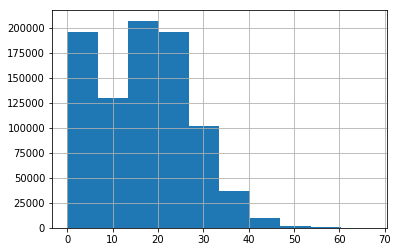

In [73]:
(pd.Series(dfmg.values.ravel())).hist()

In [74]:
# confident enrichment threshold set to 5 fold 

In [75]:
if (dist == 'jaccard' ) and (link == 'complete'):
    dfmg = dfmg > 0
    dfmg.head(2)

HTMCP-03-06-02001  HTMCP-03-06-02002  \
chr_pro chr_pro_start chr_pro_end                                         
1       34081         38080                    False              False   
        858261        862260                    True               True   

                                   HTMCP-03-06-02006  HTMCP-03-06-02012  \
chr_pro chr_pro_start chr_pro_end                                         
1       34081         38080                    False              False   
        858261        862260                    True               True   

                                   HTMCP-03-06-02020  HTMCP-03-06-02036  \
chr_pro chr_pro_start chr_pro_end                                         
1       34081         38080                    False               True   
        858261        862260                    True               True   

                                   HTMCP-03-06-02037  HTMCP-03-06-02040  \
chr_pro chr_pro_start chr_pro_end                                         
1       34081         38080                     True              False   
        858261        862260                    True               True   

                                   HTMCP-03-06-02042  HTMCP-03-06-02046  \
chr_pro chr_pro_start chr_pro_end                                         
1       34081         38080                    False              False   
        858261        862260                    True               True   

                                         ...          HTMCP-03-06-02230  \
chr_pro chr_pro_start chr_pro_end        ...                              
1       34081         38080              ...                       True   
        858261        862260             ...                       True   

                                   HTMCP-03-06-02235  HTMCP-03-06-02260  \
chr_pro chr_pro_start chr_pro_end                                         
1       34081         38080                    False              False   
        858261        862260                    True               True   

                                   HTMCP-03-06-02261  HTMCP-03-06-02266  \
chr_pro chr_pro_start chr_pro_end                                         
1       34081         38080                    False               True   
        858261        862260                    True               True   

                                   HTMCP-03-06-02267  HTMCP-03-06-02268  \
chr_pro chr_pro_start chr_pro_end                                         
1       34081         38080                    False              False   
        858261        862260                    True               True   

                                   HTMCP-03-06-02320  HTMCP-03-06-02330  \
chr_pro chr_pro_start chr_pro_end                                         
1       34081         38080                    False              False   
        858261        862260                    True               True   

                                   HTMCP-03-06-02332  
chr_pro chr_pro_start chr_pro_end                     
1       34081         38080                    False  
        858261        862260                    True  

[2 rows x 51 columns]

In [76]:
(dfmg.sum(axis=1) > 0.9*54).sum()
(dfmg.sum(axis=1) < 0.1*54).sum()
0.9*54
0.1*54

11974

1604

48.6

5.4

In [77]:
dfmg.head(2)

HTMCP-03-06-02001  HTMCP-03-06-02002  \
chr_pro chr_pro_start chr_pro_end                                         
1       34081         38080                    False              False   
        858261        862260                    True               True   

                                   HTMCP-03-06-02006  HTMCP-03-06-02012  \
chr_pro chr_pro_start chr_pro_end                                         
1       34081         38080                    False              False   
        858261        862260                    True               True   

                                   HTMCP-03-06-02020  HTMCP-03-06-02036  \
chr_pro chr_pro_start chr_pro_end                                         
1       34081         38080                    False               True   
        858261        862260                    True               True   

                                   HTMCP-03-06-02037  HTMCP-03-06-02040  \
chr_pro chr_pro_start chr_pro_end                                         
1       34081         38080                     True              False   
        858261        862260                    True               True   

                                   HTMCP-03-06-02042  HTMCP-03-06-02046  \
chr_pro chr_pro_start chr_pro_end                                         
1       34081         38080                    False              False   
        858261        862260                    True               True   

                                         ...          HTMCP-03-06-02230  \
chr_pro chr_pro_start chr_pro_end        ...                              
1       34081         38080              ...                       True   
        858261        862260             ...                       True   

                                   HTMCP-03-06-02235  HTMCP-03-06-02260  \
chr_pro chr_pro_start chr_pro_end                                         
1       34081         38080                    False              False   
        858261        862260                    True               True   

                                   HTMCP-03-06-02261  HTMCP-03-06-02266  \
chr_pro chr_pro_start chr_pro_end                                         
1       34081         38080                    False               True   
        858261        862260                    True               True   

                                   HTMCP-03-06-02267  HTMCP-03-06-02268  \
chr_pro chr_pro_start chr_pro_end                                         
1       34081         38080                    False              False   
        858261        862260                    True               True   

                                   HTMCP-03-06-02320  HTMCP-03-06-02330  \
chr_pro chr_pro_start chr_pro_end                                         
1       34081         38080                    False              False   
        858261        862260                    True               True   

                                   HTMCP-03-06-02332  
chr_pro chr_pro_start chr_pro_end                     
1       34081         38080                    False  
        858261        862260                    True  

[2 rows x 51 columns]

In [78]:

df_covariates = pd.read_csv(covariate_file, index_col='patient', sep='\t')
# df_covariates.strelka_mutations = df_covariates.strelka_mutations.astype('int64')
df_covariates = df_covariates.T.fillna('unknown')
df_covariates.head(2)

patient,HTMCP-03-06-02001,HTMCP-03-06-02002,HTMCP-03-06-02006,HTMCP-03-06-02007,HTMCP-03-06-02012,HTMCP-03-06-02020,HTMCP-03-06-02026,HTMCP-03-06-02036,HTMCP-03-06-02037,HTMCP-03-06-02040,...,HTMCP-03-06-02235,HTMCP-03-06-02256,HTMCP-03-06-02260,HTMCP-03-06-02261,HTMCP-03-06-02266,HTMCP-03-06-02267,HTMCP-03-06-02268,HTMCP-03-06-02320,HTMCP-03-06-02330,HTMCP-03-06-02332
epi_mutated,Mutated,Mutated,Mutated,Mutated,Mutated,Mutated,Mutated,Wild Type,Wild Type,Mutated,...,Wild Type,Mutated,Mutated,Wild Type,Mutated,Wild Type,Mutated,Mutated,Mutated,Mutated
Remodeller,Wild Type,Wild Type,Mutated,Mutated,Mutated,Mutated,Mutated,Wild Type,Wild Type,Mutated,...,Wild Type,Wild Type,Mutated,Wild Type,Mutated,Wild Type,Wild Type,Wild Type,Wild Type,Mutated


In [79]:
def order_covariates(df_covariates, dfmg):
    df_covariates = df_covariates.drop(['Testis-specific chromatin protein', 'REST corepressor',
           'ISWI chromatin remdelling','RNF20/40 complex','strelka_mutations', 'HPV_status'])

    dftmp = df_covariates.drop(['HIV_status', 'clinic_histology', 'tumor_grade', \
                                'age_at_diagnosis', 'epi_mutated']).apply(lambda x: x.map({'Mutated':True, 'Wild Type':False}))
    dftmp = dftmp.T
    fig = plt.figure(figsize=(12,4))
    ax1 = fig.add_subplot(211)
    ax2 = fig.add_subplot(212)
    
    feature_labels = plot_dengrogram(dftmp, ax1, dist, link)
    df_covariates  = df_covariates.reindex(['HIV_status', 'clinic_histology', 'tumor_grade', 'epi_mutated']\
                                           + feature_labels)
    
    feature_labels = df_covariates.index.tolist()
    sample_labels = plot_dengrogram(dfmg, ax2, dist, link)
    
    df_covariates = order_df(df_covariates, feature_labels, sample_labels)
    return df_covariates

    

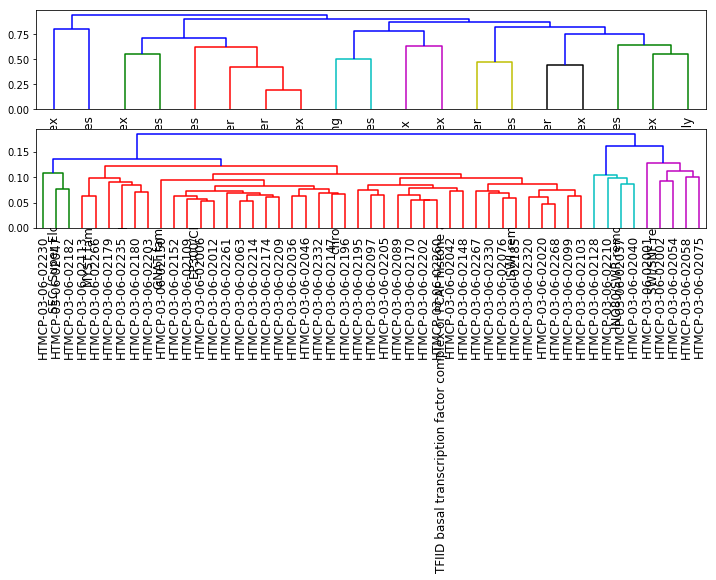

In [80]:
df_covariates = order_covariates(df_covariates, dfmg)

In [81]:
covariate_dict = get_legend_categories(df_covariates)

In [82]:
covariate_dict

{'HIV_status': ['Negative', 'Positive'],
 'clinic_histology': ['Adeno', 'Adenosquamous', 'Neuroendocrine', 'Squamous'],
 'tumor_grade': ['G1', 'G2', 'G3', 'unknown'],
 'epi_mutated': ['Mutated', 'Wild Type']}

In [83]:
df_covariates.shape

(23, 51)

In [84]:
dfmg.shape

(17230, 51)

CPU times: user 3.62 s, sys: 288 ms, total: 3.9 s
Wall time: 3.91 s


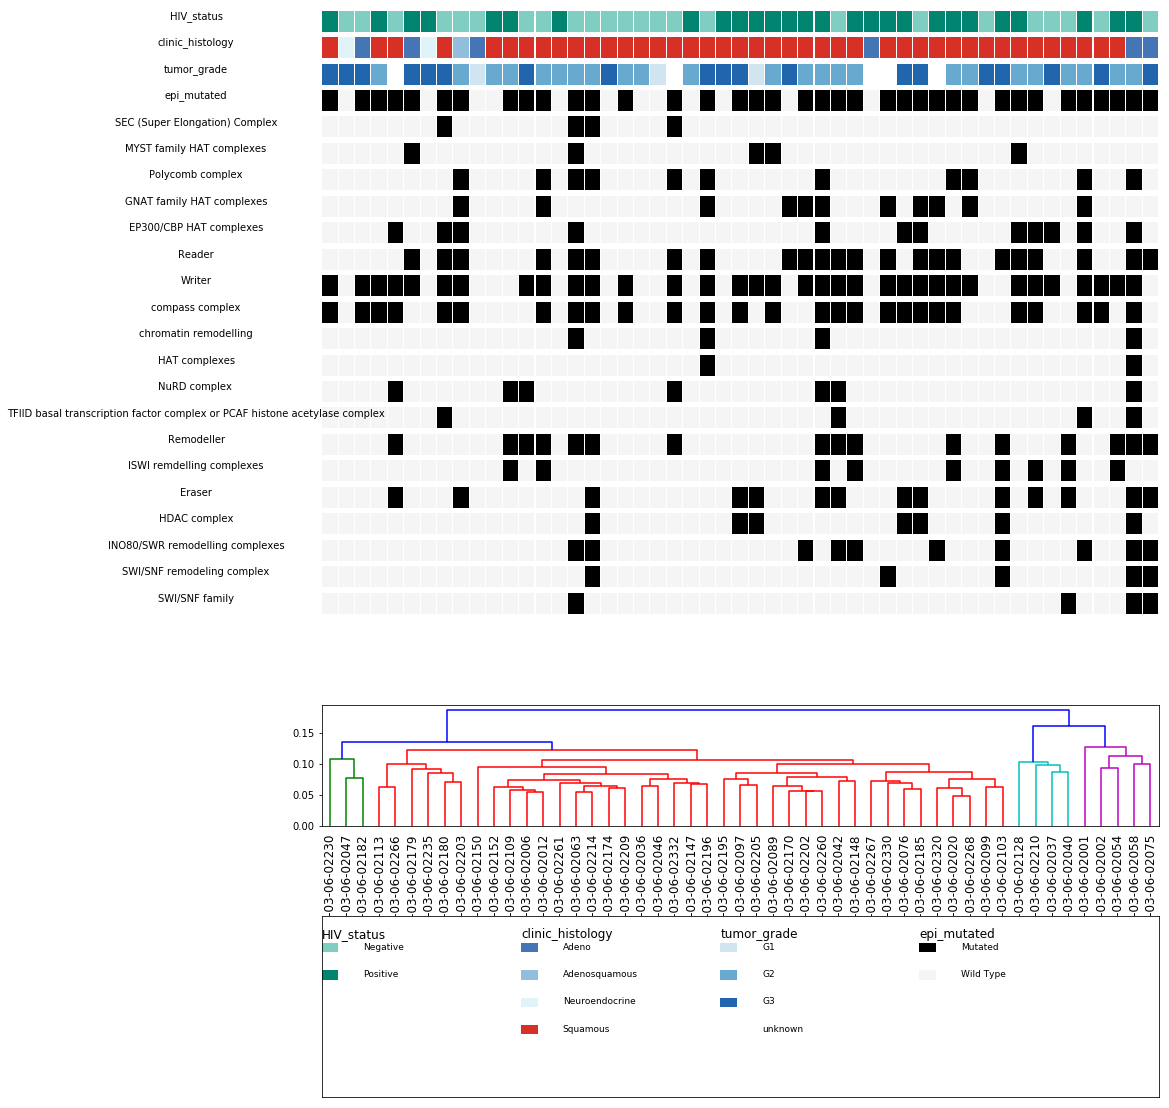

['HTMCP-03-06-02230',
 'HTMCP-03-06-02047',
 'HTMCP-03-06-02182',
 'HTMCP-03-06-02113',
 'HTMCP-03-06-02266',
 'HTMCP-03-06-02179',
 'HTMCP-03-06-02235',
 'HTMCP-03-06-02180',
 'HTMCP-03-06-02203',
 'HTMCP-03-06-02150',
 'HTMCP-03-06-02152',
 'HTMCP-03-06-02109',
 'HTMCP-03-06-02006',
 'HTMCP-03-06-02012',
 'HTMCP-03-06-02261',
 'HTMCP-03-06-02063',
 'HTMCP-03-06-02214',
 'HTMCP-03-06-02174',
 'HTMCP-03-06-02209',
 'HTMCP-03-06-02036',
 'HTMCP-03-06-02046',
 'HTMCP-03-06-02332',
 'HTMCP-03-06-02147',
 'HTMCP-03-06-02196',
 'HTMCP-03-06-02195',
 'HTMCP-03-06-02097',
 'HTMCP-03-06-02205',
 'HTMCP-03-06-02089',
 'HTMCP-03-06-02170',
 'HTMCP-03-06-02202',
 'HTMCP-03-06-02260',
 'HTMCP-03-06-02042',
 'HTMCP-03-06-02148',
 'HTMCP-03-06-02267',
 'HTMCP-03-06-02330',
 'HTMCP-03-06-02076',
 'HTMCP-03-06-02185',
 'HTMCP-03-06-02320',
 'HTMCP-03-06-02020',
 'HTMCP-03-06-02268',
 'HTMCP-03-06-02099',
 'HTMCP-03-06-02103',
 'HTMCP-03-06-02128',
 'HTMCP-03-06-02210',
 'HTMCP-03-06-02037',
 'HTMCP-03

In [85]:
plot_cluster_heatmap(dfmg, df_covariates, dist, link)